# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

В данном проекте я решаю задачу, где бурлить новую скважену. Для этого я исследую данные о месторождениях трёх регионов и строю модель, которая определяет регион, в котором бурлить новую скважену будет наиболее прибыльно. Я оцениваю прибыль и риски от бурления скважены в данном регионе. 

## Загрузка и подготовка данных

In [2]:
# загружаю библиотеки
import warnings
warnings.filterwarnings('ignore') # отключим предупреждения, чтобы не отвлекали
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import shap

In [3]:
# загружаю данные
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')
display(data_0.head())
display(data_1.head())
data_2.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
# Список с названием таблиц
data_list = [data_0, data_1, data_2]

In [5]:
# смотрю на данные
for data in data_list:
    display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

В наших датасетах в каждом по 100000 наблюдений, пропусков нет.

In [6]:
# Посмотрим на таблицу корреляций
for data in data_list:
    display(data.corr().style.background_gradient('coolwarm'))

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Во всех трёх регионах признак f2 очень сильно скоррелирован с величиной добычи, но особенно сильно это видно в регионе 1, где корреляция практически 1. 

В данном разделе я загрузила и посмотрела на данные по местораждениям нефти в трёх регионах. Дополнительная обработка данных не потребовалосб.

## Обучение и проверка модели

### Разбиение на подвыборки

Данные каждого региона разбиваю на обучающую и валидационные выборки в пропорции 3:1.

In [7]:
# Функция, разбивающая на подвыборки
def split(data):
    features = data.drop(['product','id'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = (
    train_test_split(features, target, test_size=0.25, random_state=42)
)
    return features_train, features_valid, target_train, target_valid

In [8]:
# Применим функцию к данным каждого региона
features_train_0, features_valid_0, target_train_0, target_valid_0 = split(data_0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = split(data_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = split(data_2)

In [9]:
# Списки с фичами и таргетами
features_train_list = [features_train_0, features_train_1, features_train_2]
features_valid_list = [features_valid_0, features_valid_1, features_valid_2]
target_train_list = [target_train_0, target_train_1, target_train_2]
target_valid_list = [target_valid_0, target_valid_1, target_valid_2]

In [10]:
# Посмотрим на разбиение
for i in features_train_list:
    display(i.shape[0])
    
for i in features_valid_list:
    display(i.shape[0])
    
for i in target_train_list:
    display(i.shape[0])
    
for i in target_valid_list:
    display(i.shape[0])

75000

75000

75000

25000

25000

25000

75000

75000

75000

25000

25000

25000

Я правильно разбила данные регионов на обучающую и валидационную выборки.

### Обучение моделей

Для каждого региона я обучаю модель линейной регрессии (по условию задачи) на тренировочкой выборке и потом делаю продсказания на валидационной выборке. 

In [11]:
# Инициализирую скайлер и модель
scalar = StandardScaler()
model = LinearRegression()

In [12]:
# Создаю пайплайн
pipeline = make_pipeline(scalar, model)

In [13]:
# Функция обучающая модель
def predict(features_train, target_train, features_valid, target_valid):
    pipeline.fit(features_train, target_train)
    predictions = pipeline.predict(features_valid)
    mean = predictions.mean()
    rmse = mean_squared_error(target_valid, predictions, squared=False)
    return predictions, mean, rmse

In [14]:
# Значения для каждого региона
predictions_0, mean_0, rmse_0 = predict(features_train_0, target_train_0, features_valid_0, target_valid_0)
predictions_1, mean_1, rmse_1 = predict(features_train_1, target_train_1, features_valid_1, target_valid_1)
predictions_2, mean_2, rmse_2 = predict(features_train_2, target_train_2, features_valid_2, target_valid_2)

In [15]:
# Функция визуализации вектора Шепли
def shapley(features_train, target_train, features_valid):
    features_train_summary = shap.kmeans(features_train, 10)
    pipeline.fit(features_train, target_train)
    ex = shap.KernelExplainer(pipeline.predict, features_train_summary)
    shap_values = ex.shap_values(features_valid)
    shap.summary_plot(shap_values, features_valid)

In [17]:
# для региона 0
shapley(features_train_0, target_train_0, features_valid_0)

In [ ]:
# для региона 1
shapley(features_train_1, target_train_1, features_valid_1)

In [ ]:
# для региона 2
shapley(features_train_2, target_train_2, features_valid_2)

Как мы и предполагали, признак f2 оказывает несравнимо больший вклад в таргер по сравнению со всеми остальынми признаками. Кроме того, на графиках снова видно, что регион 1 выделяется по сравнению с остальными регионами - выглядит, как будто бы распределение f2 в регионе 1 дискретное, тогда как в других регионах оно более непрерывное. Сравним на гистограммах.

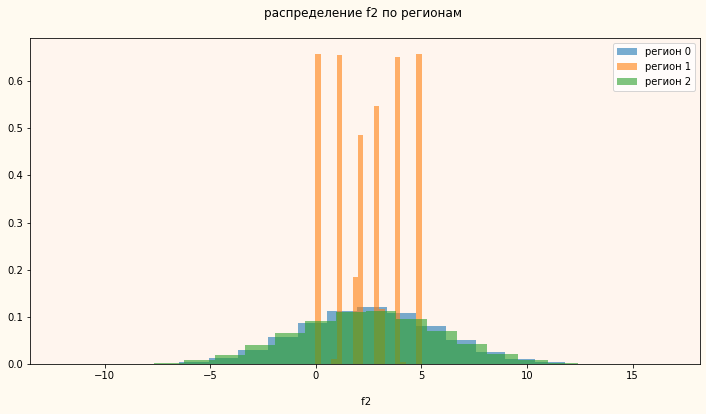

In [16]:
# Строю гистограмму
fig, ax = plt.subplots()
plt.hist(data_0['f2'], bins = 20, alpha=0.6, label = 'регион 0', density = True)
plt.hist(data_1['f2'], bins = 20, alpha=0.6, label = 'регион 1', density = True)
plt.hist(data_2['f2'], bins = 20, alpha=0.6, label = 'регион 2', density = True)
plt.legend(loc = 'upper right')
plt.xlabel('\n f2')
fig.set_figwidth(12)    
fig.set_figheight(6)    
plt.title('распределение f2 по регионам \n')
plt.ticklabel_format(useOffset=False, style='plain')
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')
plt.show()

Действительно по какой-то причине f2 в регионе 1 имеет практически дискретное распределёние, тогда как в других регионах это не так. Кроме того, support распределения в регионе 1 меньше, чем в других регионах. Без информации о признаках сложно сказать, это аномалия данных или это какая-то особенность залежей нефти в регионе 1. 

### Результаты моделей

In [17]:
# Таблица
result = pd.DataFrame([[mean_0, rmse_0], [mean_1, rmse_1], [mean_2, rmse_2]],
    index=['Регион 0', 'Регион 1', 'Регион 2'], 
    columns=['Среднее предсказание запасов', 'RMSE']
)
result

,Среднее предсказание запасов,RMSE
Регион 0,92.398800,37.756600
Регион 1,68.712878,0.890280
Регион 2,94.771024,40.145872


Опять регион 1 очень существенно отличается от остальных. Среднее предсказанное колличество запасов оказалось меньше, чем в других регионах и при этом предсказание получилось очень точным.

В данном разделе я обучила линейные регрессии для каждого из трёх регионов на обучающих выборках в данных регионах. Я сделала предсказания добычи на валидационной выборке и для каждого региона посчитала среднюю предсказываемую добычу и корень среднего квадратичного отклонения. В регионах 0 и 2 модель предсказывает среднюю добычу выше, но при этом и ошибка предсказаний сильно выше, чем в регионе 1. 

## Подготовка к расчёту прибыли

В данном разделе я буду подсчитывать необходимую добычу для безубыточной разработки новой скважины.

In [18]:
# Сохраняю константы
BUDGET = 10**10
REVENUE_PER_UNIT = 450000
N=200 # число скважин в новом месторождении

Чтобы у нас была безубыточная разработка, должно удовлетворяться следующее неравенство:
$R*Q-B\ge0$,
где $R$ - это доход на единицу, $Q$ - общий объём добычи в месторождении, а $B$ - бюджет. Тогда минимальный необходимый объём добычи для безубыточной разработки можно найти из $Q_{min} = \frac{B}{R}$

In [19]:
# Подсчёт минимального уровня добычи
q_min = BUDGET/REVENUE_PER_UNIT
display(round(q_min,1))

22222.2

Чтобы разработка нового месторождения была безубыточной, добыча должна быть не меньше, чем 22222.2 тысяч баррелей. Поскольку в месторождении будет 200 скважин, это означает, что на скважину добыча должна быть не меньше 111.1 тысяч баррелей. Наши предсказания средней добычи по скважинам немного ниже этой цифры. В следующих разделах, я буду оценивать распределение прибыли и вероятности убытков.

В данном разделе я рассчитала минимальный объём добычи в местораждение, который окупит стоимость разработки.

## Расчёт прибыли и рисков 

### Функция прибыли

Для рассчёта прибыли от разработки в каждом из регионов я буду из данных выбирать случайно 500 скважин и из них выбирать 200 с наибольших предсказанием добычи и рассчитывать прибыль на основе этих данных. 

In [20]:
# Задаю случайный стэйт
state = np.random.RandomState(12345)

In [21]:
# Функция для подвыборки из 500 скважин для региона
def profit(predictions, target, count):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:count]
    return REVENUE_PER_UNIT * selected.sum() - BUDGET

В данном разделе я создала функцию для оценки прибыли. Из предсказаний я выбираю 200 с наибольшими прогнозами добычи. на данных о действительных запасах этих скважин подсчитывается прибыль от разработки. 

### Подсчёт прибыли и рисков

In [39]:
# Функция подсчёта распределения прибыли
def profit_distribution(predictions, target):
    values = []
    for i in range(1000):
        data = (
            pd.concat([pd.Series(target,name='target'), 
                       pd.Series(predictions, name='predictions', index=target.index)], axis=1))
        data_sample = data.sample(random_state=state, n=500, replace=False)
        target_sample = data_sample['target']
        predictions_sample = data_sample['predictions']
        profit_sample = profit(predictions_sample, target_sample, N)
        values.append(profit_sample)
    distribution = pd.Series(values)
    profit_mean = distribution.mean()
    lower = distribution.quantile(0.025)
    upper = distribution.quantile(0.975)
    risk = (distribution<0).mean()
    return distribution, profit_mean, lower, upper, risk

In [40]:
# Для каждого региона
profit_distribution_0, profit_mean_0, lower_0, upper_0, risk_0 = profit_distribution(predictions_0, target_valid_0)
profit_distribution_1, profit_mean_1, lower_1, upper_1, risk_1 = profit_distribution(predictions_1, target_valid_1)
profit_distribution_2, profit_mean_2, lower_2, upper_2, risk_2 = profit_distribution(predictions_2, target_valid_2)

Посмотрим на распределение ожидаемой прибыли для трёх регионов.

In [46]:
def histogram(distribution, lower, upper, profit_mean, label, title):
    fig, ax = plt.subplots()
    plt.hist(distribution/10**6, bins = 20, alpha=0.6, label = label, density = True)
    plt.axvline(x = lower/10**6, color = 'b')
    plt.axvline(x = upper/10**6, color = 'b')
    plt.axvline(x = profit_mean/10**6, color = 'r')
    plt.xlim(-425, 1225)
    plt.xlabel('\n млн.р.')
    plt.legend(loc = 'upper right')
    fig.set_figwidth(12)    
    fig.set_figheight(6)    
    plt.title(title)
    plt.ticklabel_format(useOffset=False, style='plain')
    fig.set_facecolor('floralwhite')
    ax.set_facecolor('seashell')
    plt.show()  

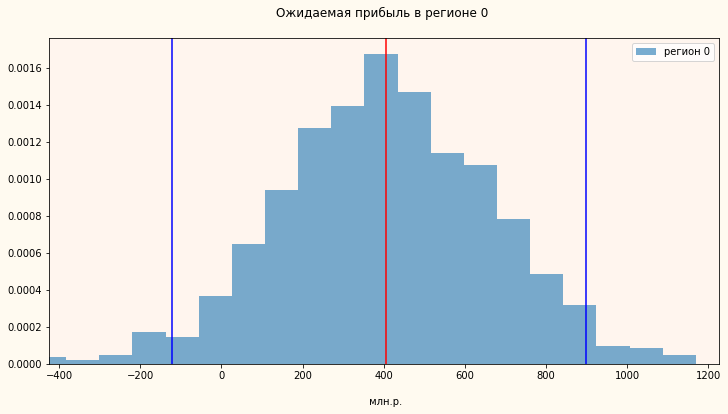

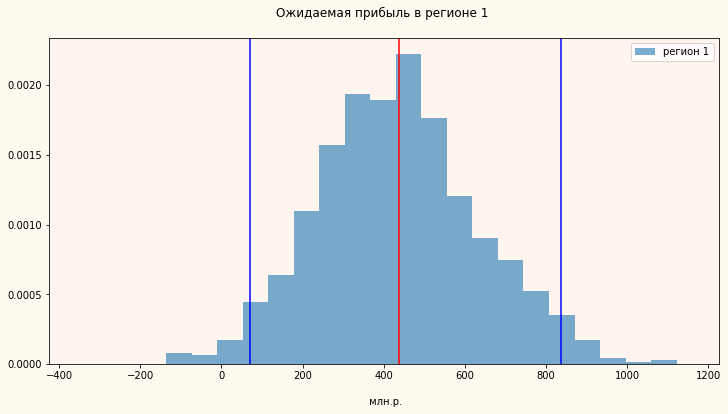

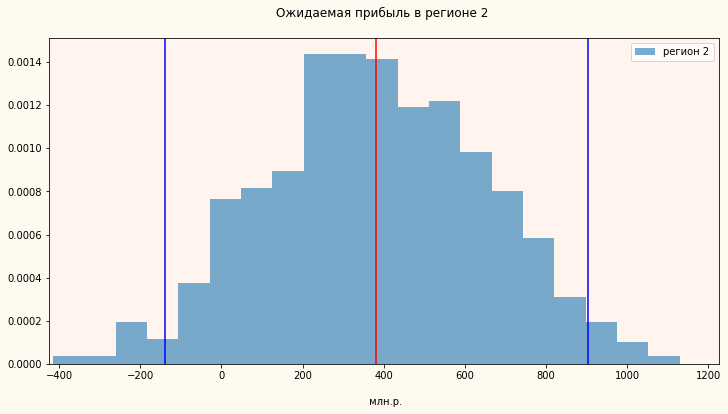

In [47]:
histogram(profit_distribution_0, lower_0, upper_0, profit_mean_0, 'регион 0', 'Ожидаемая прибыль в регионе 0 \n')
histogram(profit_distribution_1, lower_1, upper_1, profit_mean_1, 'регион 1', 'Ожидаемая прибыль в регионе 1 \n')
histogram(profit_distribution_2, lower_2, upper_2, profit_mean_2, 'регион 2', 'Ожидаемая прибыль в регионе 2 \n')

Из графиков мы видим, что распределение прибыли в регионе 1 наиболее выгодное для новой разработки - среднее выше и разброс меньше (стохастическая доминация первого рода).

Сравню числовые показатели для каждого региона.

In [49]:
# Таблица
result = (
    pd.DataFrame([[profit_mean_0/10**6, lower_0/10**6, upper_0/10**6, risk_0], 
                  [profit_mean_1/10**6, lower_1/10**6, upper_1/10**6, risk_1], 
                  [profit_mean_2/10**6, lower_2/10**6, upper_2/10**6, risk_2]],
    index=['Регион 0', 'Регион 1', 'Регион 2'], 
    columns=['Средняя прибыль, млн.р.', '2.5% квантиль', '97.5% квантиль', 'риск убытка']
))
(result.
 style.
 format({'Средняя прибыль, млн.р.':"{:,.2f}",'2.5% квантиль':"{:,.2f}", '97.5% квантиль':"{:,.2f}", 'риск убытка':"{:,.1%}"})
)

,"Средняя прибыль, млн.р.",2.5% квантиль,97.5% квантиль,риск убытка
Регион 0,406.01,-122.70,897.18,5.7%
Регион 1,436.90,71.02,835.89,0.9%
Регион 2,381.61,-138.89,902.70,7.9%


В таблице тоже видно, средняя прибыль от разработки в регионе 1 выше, и при этом риск убытка минимальный. В двух других регионах риск убытка к тому же выше, чем пороговое значение в 2.5%, которое предъявил заказчик.

В данном проекте я решала задачу выбора региона для разработки нового нефтяного месторождения. У меня в распоряжении были данные о запасах в скважинах в трёх регионах. На основании этих данных я разбила выборки на обучающие и валидационные. Для каждого региона обучила модель линейной регрессии и предстаказала уровни добычи для тестовой. Как средние уровни предсказанной добычи так и корень среднего квадратичного отклонения оказались выше в регионах 0 и 2, в то время как регион 1 сильно отличался. Я построила функцию, которая считает прибыль от 200 скважим с наибольшей предсказанной добычей. С помощью бутсрапа я оценила распределение прибыли в каждом из трёх регионов, посчитала среднее и 95% доверительный интервал, а так же вероятность убытка. Распределение прибыли в каждом регионе показало, что разведка нового месторождения будет наиболее выгодна в регионе 1. В данном регионе средняя прибыль получилась выше, доверительный интервал для прибыли тоже полностью попадает в регион положительной прибыли, а риск убытка минимальный.